## Dynamic time dependent Bayesian Optimization

This example demonstrates time dependent optimization with dynamic parameter changes.

In [1]:
from xopt.generators.bayesian.upper_confidence_bound import TDUpperConfidenceBoundGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
import warnings
warnings.filterwarnings("ignore")

In [2]:
# test evaluate function and vocs
import time
start_time = time.time()
#global eval_iteration
eval_iteration = 0
def f(inputs):
    #global eval_iteration
    x_ = inputs["x"]
    current_time = time.time()
    #t_ = eval_iteration
    #eval_iteration += 5
    t_ = current_time - start_time
    y_ = 5*(x_ - t_*1e-2)**2
    return {"y":y_, "time":current_time}

variables = {"x":[-1,1]}
objectives = {"y": "MINIMIZE"}

vocs = VOCS(variables=variables, objectives=objectives)
print(vocs)

def make_evaluator():
    return Evaluator(function=f)
evaluator = make_evaluator()

def make_generator():
    generator = TDUpperConfidenceBoundGenerator(vocs)
    generator.options.n_initial = 3
    generator.options.acq.added_time=2.0
    generator.options.acq.beta = 2.0
    #generator.options.model.use_low_noise_prior = True
    return generator

generator = make_generator()

variables={'x': [-1.0, 1.0]} constraints={} objectives={'y': 'MINIMIZE'} constants={} linked_variables={}


In [3]:
from xopt import Xopt
X = Xopt(evaluator=make_evaluator(), generator=make_generator(), vocs=vocs)

In [4]:
# See current options
X.generator.options.dict()

{'optim': {'num_restarts': 5,
  'raw_samples': 20,
  'sequential': True,
  'use_nearby_initial_points': True,
  'max_travel_distances': None},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'added_time': 2.0,
  'beta': 2.0},
 'model': {'function': <function xopt.generators.bayesian.models.time_dependent.create_time_dependent_model(data, vocs, added_time: float = 0.0, use_conservative_prior_lengthscale: bool = False, use_conservative_prior_mean: bool = False, use_low_noise_prior: bool = False) -> botorch.models.model_list_gp_regression.ModelListGP>,
  'kwargs': {'use_conservative_prior_lengthscale': False,
   'use_conservative_prior_mean': False,
   'use_low_noise_prior': False}},
 'n_initial': 3}

In [5]:
modified_options = {'acq':{'added_time':3.5}}

In [6]:
print(X.generator.generate(1))

{'x': array([ 0.38193231, -0.86114932,  0.99308051])}


In [7]:
# this does not create any permanent changes
print(X.generator.generate_custom(1, config_changes=modified_options, is_permanent=False))
print(X.generator.options.dict()['acq'])

({'x': array([-0.08100383, -0.7195201 ,  0.55484437])}, TDUCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True, max_travel_distances=None), acq=TDUpperConfidenceBoundOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128, added_time=3.5, beta=2.0), model=TDModelOptions(function=<function create_time_dependent_model at 0x00000273AC0FB700>, kwargs=kwargs(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=False)), n_initial=3))
{'proximal_lengthscales': None, 'use_transformed_proximal_weights': True, 'monte_carlo_samples': 128, 'added_time': 2.0, 'beta': 2.0}


In [8]:
# Modifications are validated against model and can be refused
try:
    X.generator.generate_custom(1, config_changes={'acq':{'added_time':'abc'}})
except Exception as ex:
    print(ex)

1 validation error for TDUCBOptions
acq -> added_time
  value is not a valid float (type=type_error.float)


In [9]:
# Now, changes are retained
print(X.generator.generate_custom(1, config_changes=modified_options, is_permanent=True))
print(X.generator.options.dict()['acq'])

({'x': array([ 0.65655506, -0.55550358,  0.72544916])}, TDUCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True, max_travel_distances=None), acq=TDUpperConfidenceBoundOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128, added_time=3.5, beta=2.0), model=TDModelOptions(function=<function create_time_dependent_model at 0x00000273AC0FB700>, kwargs=kwargs(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=False)), n_initial=3))
{'proximal_lengthscales': None, 'use_transformed_proximal_weights': True, 'monte_carlo_samples': 128, 'added_time': 3.5, 'beta': 2.0}


In [10]:
# If step interface is used, any options changes are stored in history
X = Xopt(evaluator=make_evaluator(), generator=make_generator(), vocs=vocs)
X.step()
X.step(generator_opts=modified_options, is_permanent=False)
X.step()

In [11]:
for x in X._generator_options_history:
    print(x)
    print()

{'is_permanent': False, 'config_change': None, 'n': 1, 'effective_config': {'optim': {'num_restarts': 5, 'raw_samples': 20, 'sequential': True, 'use_nearby_initial_points': True, 'max_travel_distances': None}, 'acq': {'proximal_lengthscales': None, 'use_transformed_proximal_weights': True, 'monte_carlo_samples': 128, 'added_time': 2.0, 'beta': 2.0}, 'model': {'function': <function create_time_dependent_model at 0x00000273AC0FB700>, 'kwargs': {'use_conservative_prior_lengthscale': False, 'use_conservative_prior_mean': False, 'use_low_noise_prior': False}}, 'n_initial': 3}}

{'is_permanent': False, 'config_change': {'acq': {'added_time': 3.5}}, 'n': 1, 'effective_config': TDUCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True, max_travel_distances=None), acq=TDUpperConfidenceBoundOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128, added_time=3.5, beta=2.0), model=TDModelOptions(functi

In [12]:
# History can be used to recover state at a specific step
X.rollback(step=1)
for x in X._generator_options_history:
    print(x)
    print()
display(X.data)

{'is_permanent': False, 'config_change': None, 'n': 1, 'effective_config': {'optim': {'num_restarts': 5, 'raw_samples': 20, 'sequential': True, 'use_nearby_initial_points': True, 'max_travel_distances': None}, 'acq': {'proximal_lengthscales': None, 'use_transformed_proximal_weights': True, 'monte_carlo_samples': 128, 'added_time': 2.0, 'beta': 2.0}, 'model': {'function': <function create_time_dependent_model at 0x00000273AC0FB700>, 'kwargs': {'use_conservative_prior_lengthscale': False, 'use_conservative_prior_mean': False, 'use_low_noise_prior': False}}, 'n_initial': 3}}



,x,y,time,xopt_runtime,xopt_error
1,0.304052,0.184921,1.667334e+09,0.000006,False


In [13]:
# Full loop with adaptive time step (for example, because of thermal effects each next measurement is slower)
X = Xopt(evaluator=make_evaluator(), generator=make_generator(), vocs=vocs)
eval_iteration = 0
for i in range(15):
    X.step(generator_opts={'acq':{'added_time':1.0*(i/2+1)}})
    time.sleep(0.1)

In [14]:
X.data

,x,y,time,xopt_runtime,xopt_error
1,-0.680083,3.678459,1.667334e+09,0.000006,False
2,0.438875,0.341216,1.667334e+09,0.000001,False
3,0.463769,0.409345,1.667334e+09,0.000001,False
4,0.470096,0.381614,1.667334e+09,0.000005,False
5,1.000000,3.080716,1.667334e+09,0.000007,False
6,0.121250,0.072001,1.667334e+09,0.000005,False
7,0.319696,0.011188,1.667334e+09,0.000006,False
8,0.082786,0.254963,1.667334e+09,0.000005,False
9,0.322089,0.003843,1.667334e+09,0.000005,False
10,0.476745,0.032588,1.667334e+09,0.000005,False


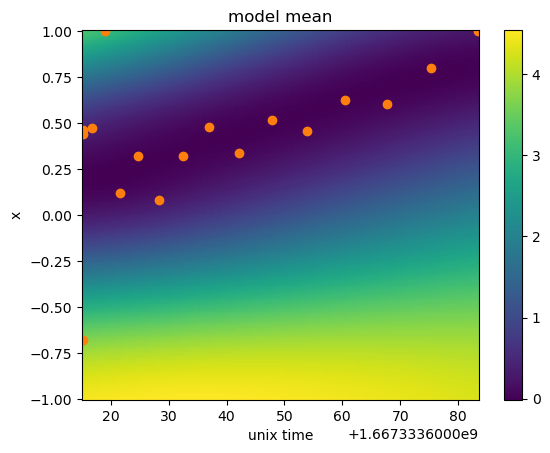

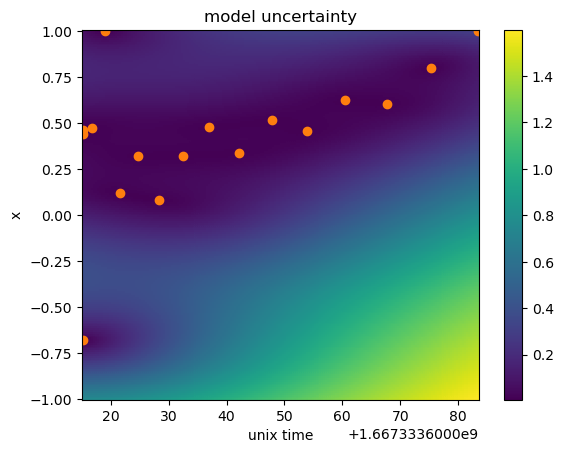

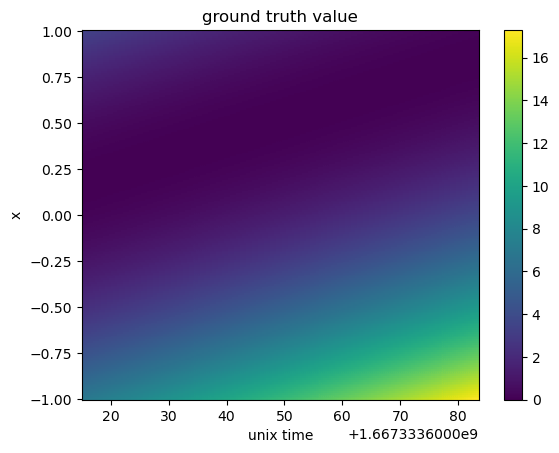

In [15]:
# plot model
import torch
from matplotlib import pyplot as plt  # plot model predictions
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

def gt(inpts):
    return 5*(inpts[:,1] - (inpts[:,0] - start_time)*1e-2)**2

model = X.generator.model
n = 200
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

#NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = gt(pts)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.set_title("model mean")
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    c = ax.pcolor(tt, xx, mean.reshape(n,n))
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    ax2.set_title("model uncertainty")
    ax2.set_xlabel("unix time")
    ax2.set_ylabel("x")
    c = ax2.pcolor(tt, xx, std.reshape(n,n))
    fig2.colorbar(c)

    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")
    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")

    fig3, ax3 = plt.subplots()
    ax3.set_title("ground truth value")
    ax3.set_xlabel("unix time")
    ax3.set_ylabel("x")
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n,n))
    fig3.colorbar(c)

In [16]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([1.0000e-04], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.raw_constant',
  Parameter containing:
  tensor(2.3620, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(3.5129, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.5311,  0.7942]], dtype=torch.float64, requires_grad=True))]